In [1]:
#import packages
import numpy as np
import copy
import pandas
import os
import imp
import pickle
from scipy.interpolate import interp1d
import warnings
import time
import matplotlib.pyplot as plt
import inspect
import types
import math as mat
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import datetime
from matplotlib import animation
from IPython.display import HTML
from tempfile import NamedTemporaryFile
import matplotlib.backends.backend_pdf
from scipy import interpolate
from itertools import groupby
import re
import csv
import copy
from fnmatch import fnmatch
import json
import h5py 
import copy
import math
pi = math.pi

sns.set()
sns.set_style()
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#ledpanels

def get_idx_panels_commands(ledpanels_command):
#gets the indeces of the set pattern id command and
# the gain command
    idx_pat_command = [i for i, x in enumerate(all_ledpanels_command[i])
               if x == b'set_pattern_id']
    idx_gain_command = [i for i, x in enumerate(all_ledpanels_command[i])
               if x == b'send_gain_bias']
    return idx_pat_command, idx_gain_command

#alicat, wind flow

def read_in_wind_flow_parameters(alicat_devices_topic):
#read in and strip the alicat message
#returns the 
    allmsg = str(alicat_devices_topic)
    allmsg_line = allmsg.split('\\n')
    
    allmsg_split = []
    for i in allmsg_line:
        msg_split = str(i).split(':')
        allmsg_split.append(msg_split)
    
    allmsg_stripped = []
    for i in allmsg_split:
        allmsg_pairs = []
        for j in i:
            msg_stripped = str(j).strip('    ')
            allmsg_pairs.append(msg_stripped)    
        allmsg_stripped.append(allmsg_pairs)
    
    return allmsg_stripped

def get_alicat_parameters(allmsg_stripped):
    
    n = 6 #number of addresses (or devices)
    
    #getting addresses
    adresses_file = []
    alicat_seq_file = []
    rate_set_point_file = []
    rate_actual_file = []
    success_file = []
    for i in range(len(allmsg_stripped)):
        for j in range(len(allmsg_stripped[i])):
            if allmsg_stripped[i][j] == 'address':
                adresses_file.append(allmsg_stripped[i][1][1])
            elif allmsg_stripped[i][j] == 'seq':
                alicat_seq_file.append(int(allmsg_stripped[i][1]))
            elif allmsg_stripped[i][j] == 'rate_set_point':
                rate_set_point_file.append(float(allmsg_stripped[i][1]))  
            elif allmsg_stripped[i][j] == 'rate_actual':
                rate_actual_file.append(float(allmsg_stripped[i][1]))   
            elif allmsg_stripped[i][j] == 'success':
                success_file.append((allmsg_stripped[i][1])) 
           
    adresses_file_dev = [adresses_file[x:x+n] for x in range(0, len(adresses_file),n)]
    rate_set_point_file_dev = [rate_set_point_file[x:x+n] for x in range(0, len(rate_set_point_file),n)]
    rate_actual_file_dev = [rate_actual_file[x:x+n] for x in range(0, len(rate_actual_file),n)]
    success_file_dev = [success_file[x:x+n] for x in range(0, len(success_file),n)]
    
    lists_to_check = [adresses_file_dev, rate_set_point_file_dev, rate_actual_file_dev, success_file_dev]
    
    for i in lists_to_check:
        for j in i:
            if len(j) != n:
                raise Exception('something is wrong with msg')
            
    for i in lists_to_check:
        if len(i) != len(alicat_seq_file):
            raise Exception('something is wrong with msg')  
            
    return alicat_seq_file, adresses_file_dev, rate_set_point_file_dev, rate_actual_file_dev, success_file_dev

def get_changes_set_point(rate_set_point_file):
    idx_changes_set_point_l = []
    for i in range(len(rate_set_point_file)-1):
        if i == 0 :
            idx = i
        elif rate_set_point_file[i] != rate_set_point_file[i+1]:
            idx = i+1
        elif i == len(rate_set_point_file)-2:
            idx = i+1 
        idx_changes_set_point_l.append(idx)
        
    idx_changes_set_point = np.unique(np.asarray(idx_changes_set_point_l))
    
    return idx_changes_set_point

def get_consecutive_pairs(myarray):
    start_frames = []
    end_frames = []
    for i in range(len(myarray)-1):
        s = myarray[i]
        e = myarray[i + 1]  
        start_frames.append(s)
        end_frames.append(e)
    return start_frames, end_frames

In [3]:
#functions
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def get_elapsed_time(my_list):
#for list of lists
    all_t_ellapsed = []
    for i in range(len(my_list)):
        t_ellapsed = my_list[i] - my_list[i][0]
        all_t_ellapsed.append(t_ellapsed)
    return all_t_ellapsed

def smallestSignedAngleBetween(x, y):
    a = math.atan2(math.sin(y-x), math.cos(y-x))
    return a

def get_smallestSignedAngleBetween(ax, y):
    yy=np.deg2rad(np.ones(len(ax))*y)
    axx = np.deg2rad(ax)
    
    array_smallestsignedangle = []
    for k in range(len(ax)):
        kk = smallestSignedAngleBetween(axx[k], yy[k])*-1
        kk = (np.rad2deg(kk))
        array_smallestsignedangle.append(kk)
    
    return array_smallestsignedangle

def circmean(alpha,axis=None):
    mean_angle = np.arctan2(np.mean(np.sin(alpha),axis),np.mean(np.cos(alpha),axis))
    return mean_angle

def circvar(alpha,axis=None):
#### vector strength = 1 - circvar
#     if np.ma.isMaskedArray(alpha) and alpha.mask.shape!=():
#         N = np.sum(~alpha.mask,axis)
#     else:
#         if axis is None:
#             N = alpha.size
#         else:
#             N = alpha.shape[axis]
    R = np.sqrt(np.sum(np.sin(alpha),axis)**2 + np.sum(np.cos(alpha),axis)**2)/len(alpha)
    V = 1-R
    return R

In [16]:
dataDir = '/Users/fponce/Documents/vdesert/temp'
pattern_vdesert_data = "*.hdf5"
exp = 'VD_100719'

#ledpanels info about patterns used:
#pattern table used from vdesert params
#pattern_angles should correspond to pattern_ids 1 to 1

pattern_ids = [1,2,3,4,5,6,7,8,\
               9,10,11,12,13,14,15,16,\
               17,18,19,20,21,22,23,24]

pattern_angles = [45, 135, 90, 180, -45, 0, -90, -135,\
                  45, 135, 90, 180, -45, 0, -90, -135,\
                  -135, 45, 135, -45, 90, 180, -90, 0]

pattern_type = [0,1,2]

# type1 - 0-8 big blobs - camo 
# type2 - 9-16 small blobs - starfield
# type3 - 17-24 stripes

#vector indicating the idx of trials that need to be analyzed
all_trials_ids = range(13)

#should be imported from some spreadsheet
number_unique_flies = 11
fly_id= [0,0,1,1,2,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10]
fly_id_trial = [0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1]

#for magnotether angle interpolation
number_trials = 10
time_each_trial = [60,60,60,60,10,180,180,180,180,180,180,180,180]
#trial_time = int(180*number_trials)
experiment_time = np.sum(np.asarray(time_each_trial))
number_frames_per_sec = 30

print(experiment_time)
print(experiment_time*30)

1690
50700


In [17]:
#import data
datapaths = []
for path, subdirs, files in os.walk(dataDir):
    for name in files:
        if fnmatch(name, pattern_vdesert_data):
            datapaths.append(os.path.join(path, name))
            
print(datapaths[-1])
print(len(datapaths))

#check for keys
for i in range(len(datapaths)):
    f = h5py.File(datapaths[i], "r")
    datasetNames = [n for n in f.keys()]
print(datasetNames)

/Users/fponce/Documents/vdesert/temp/data_2019-10-10-15-51-36.hdf5
5
['alicat_devices', 'alicat_ros_tstamps', 'alicat_tsstamp', 'angle', 'autostep_action_running', 'autostep_action_started', 'autostep_action_stopped', 'current_trial_index', 'elapsed_time', 'flow_action_running', 'flow_action_started', 'flow_action_stopped', 'init_angle', 'ledpanels_panels_arg1', 'ledpanels_panels_arg2', 'ledpanels_panels_arg3', 'ledpanels_panels_arg4', 'ledpanels_panels_arg5', 'ledpanels_panels_arg6', 'ledpanels_panels_command', 'ledpanels_ros_tstamps', 'magnotether_angle', 'magnotether_frame', 'magnotether_ros_tstamps', 'magnotether_tstamps', 'motion_data_position', 'motion_data_ros_tstamps', 'motion_data_seq', 'motion_data_setpoint', 'motion_data_time', 'motion_data_tstamps', 'name', 'panels_action_running', 'panels_action_started', 'panels_action_stopped', 'ros_tstamps', 'seq', 'sun_blue', 'sun_green', 'sun_message', 'sun_red', 'sun_ros_tstamps', 'sun_success', 'sun_tsstamp', 'trial_e_time', 'tstamp

In [18]:
#hdf5 -> np.arrays
all_params_ts = []
all_data_params = []

all_ros_ts = []
all_ts = []
all_elapsed_time = []
all_trial_index = []
all_trial_elapsed_time = []
all_angle_for_autostep = []
all_init_angle = []
all_autostep_running = []
all_autostep_started = []
all_autostep_stopped = []
all_flow_running = []
all_flow_started = []
all_flow_stopped = []
all_panels_running = []
all_panels_started = []
all_panels_stopped = []

all_magnotether_angle = []
all_magnotether_ros_tstamps = []
all_magnotether_tstamps = []

all_motion_ros_tstamps = []
all_motion_tstamps = []
all_motion_setpoint = []
all_motion_position = []

all_ledpanels_ros_tstamps = []
all_ledpanels_command = []
all_ledpanels_1 = []
all_ledpanels_2 = []
all_ledpanels_3 = []
all_ledpanels_4 = []
all_ledpanels_5 = []
all_ledpanels_6 = []

all_alicat_ros_tstamps = []
all_alicat_devices = []

all_sun_ros_tstamps = []
all_sun_red = []
all_sun_green = []
all_sun_blue = []

for i in range(len(datapaths)):
    f = h5py.File(datapaths[i], "r")
    
    #parameters topic
#     params_ts = np.asarray(f['data_params_ros_tstamps'])
#     data_params = np.asarray(f['data_params'])
    
    #virtual_desert topic
    ros_ts = np.asarray(f['ros_tstamps'])
    ts = np.asarray(f['tstamps'])
    elapsed_time = np.asarray(f['elapsed_time'])
    trial_index = np.asarray(f['current_trial_index'])
    trial_elapsed_time = np.asarray(f['trial_e_time'])
    angle_for_autostep = np.asarray(f['angle'])
    init_angle = np.asarray(f['init_angle'])
    
    #actions
    autostep_running = np.asarray(f['autostep_action_running'])
    autostep_started = np.asarray(f['autostep_action_started'])
    autostep_stopped = np.asarray(f['autostep_action_stopped'])
    
    flow_running = np.asarray(f['flow_action_running'])
    flow_started = np.asarray(f['flow_action_started'])
    flow_stopped = np.asarray(f['flow_action_stopped'])  
    
    panels_running = np.asarray(f['panels_action_running'])
    panels_started = np.asarray(f['panels_action_started'])
    panels_stopped = np.asarray(f['panels_action_stopped'])      
    
    #magnotether_angle topic
    magnotether_angle = np.asarray(f['magnotether_angle'])
    magnotether_ros_tstamps = np.asarray(f['magnotether_ros_tstamps'])
    magnotether_tstamps = np.asarray(f['magnotether_tstamps'])
    
    #motion_data topic
    motion_ros_tstamps = np.asarray(f['motion_data_ros_tstamps'])
    motion_tstamps = np.asarray(f['motion_data_tstamps'])
    motion_setpoint = np.asarray(f['motion_data_setpoint'])
    motion_position = np.asarray(f['motion_data_position'])
    
    #ledpanels topic
    ledpanels_ros_tstamps = np.asarray(f['ledpanels_ros_tstamps'])
    ledpanels_command = np.asarray(f['ledpanels_panels_command'])
    ledpanels_1 = np.asarray(f['ledpanels_panels_arg1'])
    ledpanels_2 = np.asarray(f['ledpanels_panels_arg2'])
    ledpanels_3 = np.asarray(f['ledpanels_panels_arg3'])
    ledpanels_4 = np.asarray(f['ledpanels_panels_arg4']) 
    ledpanels_5 = np.asarray(f['ledpanels_panels_arg5']) 
    ledpanels_6 = np.asarray(f['ledpanels_panels_arg6']) 
    
    #alicat topic
    alicat_ros_tstamps = np.asarray(f['alicat_ros_tstamps'])
    alicat_devices = np.asarray(f['alicat_devices'])
    
    #sun topic
    sun_ros_tstamps = np.asarray(f['sun_ros_tstamps'])
    sun_red = np.asarray(f['sun_red'])
    sun_green = np.asarray(f['sun_green'])
    sun_blue = np.asarray(f['sun_blue'])
    
    
#     all_params_ts.append(params_ts)
#     all_data_params.append(data_params)
    all_ros_ts.append(ros_ts)
    all_ts.append(ts)
    all_elapsed_time.append(elapsed_time)
    all_trial_index.append(trial_index)
    all_trial_elapsed_time.append(trial_elapsed_time)
    all_angle_for_autostep.append(angle_for_autostep)
    all_init_angle.append(init_angle)
    all_autostep_running.append(autostep_running)
    all_autostep_started.append(autostep_started)
    all_autostep_stopped.append(autostep_stopped)
    all_flow_running.append(flow_running)
    all_flow_started.append(flow_started)
    all_flow_stopped.append(flow_stopped)
    all_panels_running.append(panels_running)
    all_panels_started.append(panels_started)
    all_panels_stopped.append(panels_stopped)
    all_magnotether_angle.append(magnotether_angle)
    all_magnotether_ros_tstamps.append(magnotether_ros_tstamps)
    all_magnotether_tstamps.append(magnotether_tstamps)
    all_motion_ros_tstamps.append(motion_ros_tstamps)
    all_motion_tstamps.append(motion_tstamps)
    all_motion_setpoint.append(motion_setpoint)
    all_motion_position.append(motion_position)
    all_ledpanels_1.append(ledpanels_1)
    all_ledpanels_2.append(ledpanels_2)
    all_ledpanels_3.append(ledpanels_3)
    all_ledpanels_4.append(ledpanels_4)
    all_ledpanels_5.append(ledpanels_5)
    all_ledpanels_6.append(ledpanels_6)
    all_ledpanels_command.append(ledpanels_command)
    all_ledpanels_ros_tstamps.append(ledpanels_ros_tstamps)
    all_alicat_ros_tstamps.append(alicat_ros_tstamps)
    all_alicat_devices.append(alicat_devices)   
    all_sun_ros_tstamps.append(sun_ros_tstamps)
    all_sun_red.append(sun_red)
    all_sun_green.append(sun_green)
    all_sun_blue.append(sun_blue)

In [19]:
print(all_sun_ros_tstamps[0])

[1.57073041e+09 1.57073047e+09 1.57073053e+09 1.57073059e+09
 1.57073065e+09 1.57073066e+09 1.57073084e+09 1.57073120e+09
 1.57073156e+09 1.57073174e+09 1.57073192e+09]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


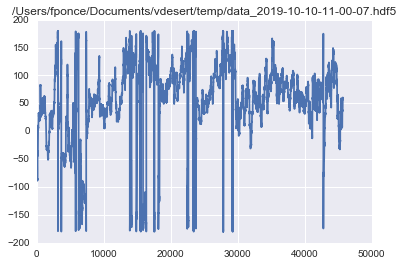

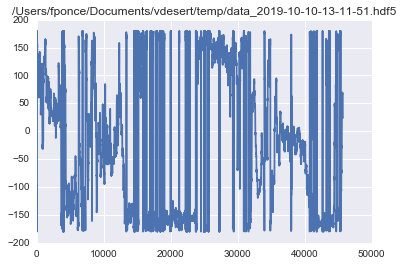

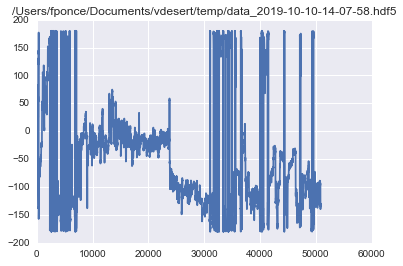

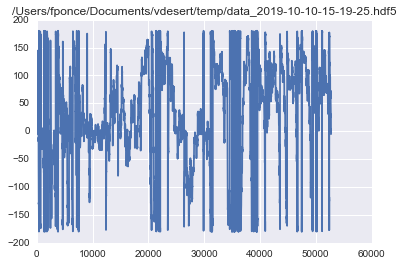

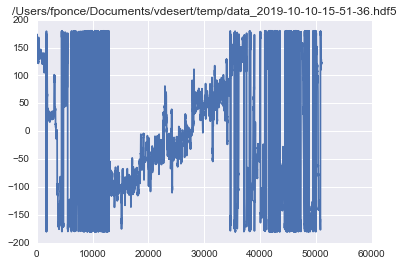

In [20]:
#quick check for flies that completed all the trials

for i in range(len(datapaths)):
    print(np.unique(all_trial_index[i]))
    
#quick look at  magnotether data
for i in range(len(all_magnotether_angle)):
    plt.figure()
    plt.plot(all_magnotether_angle[i])
    plt.title(datapaths[i])

In [ ]:
#this gets the times(all_elapsed_time) when the trial changes in the virtual desert node

all_start_times = []
all_end_times = []
for i in range(len(datapaths)):
    start_times_trials = []
    end_times_trials = []
    for j in range(number_trials):
        start_time = all_elapsed_time[i][np.where(all_trial_index[i]==j)][0]
        end_time = all_elapsed_time[i][np.where(all_trial_index[i]==j)][-1]
        start_times_trials.append(start_time)
        end_times_trials.append(end_time)
    all_start_times.append(start_times_trials)
    all_end_times.append(end_times_trials)
    
# print(all_start_times[0])
# print(all_end_times[0])

all_start_frames = []
all_end_frames = []
for i in range(len(datapaths)):
    start_frames_trials = []
    end_frames_trials = []
    for j in range((number_trials)):
        start_frame = [np.where(all_trial_index[i]==j)][0][0][0]
        end_frame = [np.where(all_trial_index[i]==j)][0][0][-1]
        start_frames_trials.append(start_frame)
        end_frames_trials.append(end_frame)
    all_start_frames.append(start_frames_trials)
    all_end_frames.append(end_frames_trials)
# print(all_start_frames[0])
# print(all_end_frames[0])

In [ ]:
#interpolation of magnotether angles

t = [0, experiment_time]
reg_t = np.linspace(t[0], t[-1],(experiment_time*number_frames_per_sec)+1)

#getting elapsed time of time stamps to use
all_ts = get_elapsed_time(all_magnotether_ros_tstamps)

#making the interpolation
all_magnotether_interp_angles = []
for i in range(len(datapaths)):       
    mysecs_np = all_ts[i]
    myangles_np = all_magnotether_angle[i]    
    f_a = interp1d(mysecs_np, myangles_np, bounds_error=False)
    reg_a = f_a(reg_t)
    all_magnotether_interp_angles.append(reg_a)

In [ ]:
#get the closest times that correspond to start and end times in the reg_t
all_magnotether_elapsed = reg_t

all_start_times_m = []    
all_end_times_m = []   
for i in range(len(all_start_times)): 
    start_times_trials_m = []
    end_times_trials_m = []    
    for j in range((number_trials)):
        start_times_m = find_nearest(all_magnotether_elapsed, all_start_times[i][j])
        end_times_m = find_nearest(all_magnotether_elapsed, all_end_times[i][j])
        start_times_trials_m.append(start_times_m)
        end_times_trials_m.append(end_times_m)
    all_start_times_m.append(start_times_trials_m)    
    all_end_times_m.append(end_times_trials_m)     
    
# print(all_start_times_m[0])   
# print(all_end_times_m[0])   

all_start_frames_m = []    
all_end_frames_m = []   
for i in range(len(all_start_times)): 
    start_frames_trials_m = []
    end_frames_trials_m = []    
    for j in range((number_trials)):
        start_frames_m = find_nearest_idx(all_magnotether_elapsed, all_start_times[i][j])
        end_frames_m = find_nearest_idx(all_magnotether_elapsed, all_end_times[i][j])
        start_frames_trials_m.append(start_frames_m)
        end_frames_trials_m.append(end_frames_m)
    all_start_frames_m.append(start_frames_trials_m)    
    all_end_frames_m.append(end_frames_trials_m)     
    
# print(all_start_frames_m[0])   
# print(all_end_frames_m[0]) 

In [ ]:
#get ledpanels info

#gets the indeces of the set pattern id command
all_idx_pat_command = []
all_idx_gain_command = []
for i in range(len(datapaths)):
    idx_pat_command, idx_gain_command = get_idx_panels_commands(ledpanels_command)
    all_idx_pat_command.append(idx_pat_command)
    all_idx_gain_command.append(idx_gain_command)
    
#get elapsed time of panels
all_ledpanels_elapsed_t = get_elapsed_time(all_ledpanels_ros_tstamps)

#get the timestamp and elapsed time of the set pattern id command
all_ros_tstamps_pat_id = []
all_ledpanels_elapsed_t_pat_id  = []
for i in range(len(all_idx_pat_command)):
    ros_tstamps_pat_id_file = []
    ledpanels_elapsed_t_pat_id_file = []
    for j in (all_idx_pat_command[i]):
        ros_tstamps_pat_id = all_ledpanels_ros_tstamps[i][j]
        ledpanels_elapsed_t_pat_id = all_ledpanels_elapsed_t[i][j]
        
        ros_tstamps_pat_id_file.append(ros_tstamps_pat_id)
        ledpanels_elapsed_t_pat_id_file.append(ledpanels_elapsed_t_pat_id)
        
    all_ros_tstamps_pat_id.append(ros_tstamps_pat_id_file)
    all_ledpanels_elapsed_t_pat_id.append(ledpanels_elapsed_t_pat_id_file) 
    
#get arg1 for pannel_id command and gains
#get the arg1 for the rows of pattern_id command
all_pattern_id = []
for i in range(len(all_idx_pat_command)):
    pattern_id_file = []
    for j in (all_idx_pat_command[i]):
        arg1 = all_ledpanels_1[i][j]
        pattern_id_file.append(arg1)
    all_pattern_id.append(pattern_id_file)
    
#get the arg1 for the rows of gain command
all_gains = []
for i in range(len(all_idx_gain_command)):
    gains_file = []
    for j in (all_idx_gain_command[i]):
        arg1 = all_ledpanels_1[i][j]
        gains_file.append(arg1)
    all_gains.append(gains_file)
    
# print(all_ledpanels_elapsed_t_pat_id[0])
# print(all_pattern_id)
print((all_gains))

In [ ]:
#get wind flow info

#get alicat parameters
all_alicat_seq = []
all_adresses = []
all_rate_set_point = []
all_rate_actual = []
all_success = []

for i in range(len(all_alicat_devices)):
    msg = read_in_wind_flow_parameters(all_alicat_devices[i])
    seq, adresses, rate_set_point, rate_actual, success = get_alicat_parameters(msg)

    all_alicat_seq.append(seq)
    all_adresses.append(adresses)
    all_rate_set_point.append(rate_set_point)
    all_rate_actual.append(rate_actual)
    all_success.append(success)

In [ ]:
#get alicat elapsed time when there were set point changes
et_a = get_elapsed_time(all_alicat_ros_tstamps)

all_start_idx_a = []    
all_end_idx_a = []   
for i in range(len(all_start_times)): 
    start_idx_trials_a = []
    end_idx_trials_a = []    
    for j in range((number_trials)):
        start_idx_a = find_nearest_idx(et_a[i], all_start_times[i][j])
        end_idx_a = find_nearest_idx(et_a[i], all_end_times[i][j])
        start_idx_trials_a.append(start_idx_a)
        end_idx_trials_a.append(end_idx_a)
    all_start_idx_a.append(start_idx_trials_a)    
    all_end_idx_a.append(end_idx_trials_a)  